# Linear Discriminant Analysis


I decided to implement linear discriminant analysis from scratch—capital S scratch. I won’t even use NumPy or Pandas; just pure Python with its humble lists, some built-in tools and the first principles of linear algebra and statistics. I've even tackled tasks like matrix multiplication and inversion from the ground up.

## Data
I've enlisted my legit health stats from Apple Health and Nike Run Club to predict whether I will run on a particular day or not. Apple Health is a goldmine of health data due to its expansive dataset and multifaceted metrics. The platform aggregates a diverse range of health and fitness information, encompassing activity levels, sleep patterns, and heart rate variations. The data was easy to export as Apple Health has a button to export your personal health data locally. The running data is just one binary variable, did I run or not run on that day, but the data was a pain to retrieve. But runners are persistent and stubborn so someone wrote a Python library to extract data from NRC. 

I will use my average heart rate recorded throughout the day and active energy burned that is the calories burned when I was physically active to predict whether I went for a run or not

I will use dataclasses to create a class that will represent a single row of the dataset. This will make it easier to work with the data, since we are not using pandas.

In [1]:
from dataclasses import dataclass
import datetime
@dataclass 
class RunData:
    Date: datetime.datetime
    MeanAppleSleepingWristTemperature: float
    TotalActiveEnergyBurned: float
    MeanHeartRate: float
    MeanHeartRateVariabilitySDNN: float
    MeanRestingHeartRate: float
    MaxHeartRate: float
    didIRun: int

    def __repr__ (self):
        return '\n'.join(map(lambda y: f'{y[0]}: {y[1]}',self.__dict__.items()))

The next step is to read the data

In [2]:
from datetime import datetime
with open("personal_health_data.csv") as f:
    raw_data = list(map(lambda x: x.split(","), f.read().splitlines()))
    convertToFloat = lambda x: float(x) if x != "" else None
    parse_datetime = lambda string: datetime.strptime(string, "%d-%m-%Y")
    DATA = [
        RunData(
            parse_datetime(Date),
            convertToFloat(MeanAppleSleepingWristTemperature),
            convertToFloat(TotalActiveEnergyBurned),
            convertToFloat(MeanHeartRate),
            convertToFloat(MeanHeartRateVariabilitySDNN),
            convertToFloat(MeanRestingHeartRate),
            convertToFloat(MaxHeartRate),
            int(didIRun),
        )
        for Date, MeanAppleSleepingWristTemperature, TotalActiveEnergyBurned, MeanHeartRate, MeanHeartRateVariabilitySDNN, MeanRestingHeartRate, MaxHeartRate, didIRun in raw_data[
            1:
        ]
    ]
print(DATA[0])

Date: 2023-11-04 00:00:00
MeanAppleSleepingWristTemperature: 34.3623
TotalActiveEnergyBurned: 1320.6378
MeanHeartRate: 108.27973
MeanHeartRateVariabilitySDNN: 50.100624
MeanRestingHeartRate: 72.0
MaxHeartRate: 174.0
didIRun: 1


In [3]:
from functools import reduce
average = lambda data, column_name: reduce(lambda x, y: x + y, map(lambda x: x.__dict__[column_name], data)) / len(data)

Next we will perform train and test split on the data

In [4]:
train = list(filter(lambda x: x.Date < datetime(2023, 12, 25), DATA))
test = list(filter(lambda x: x.Date >= datetime(2023, 12, 25), DATA))
data_given_run = list(filter(lambda x: x.didIRun == 1, train))
data_given_not_run = list(filter(lambda x: x.didIRun == 0, train))

Here we calculate the prior probabilities

In [5]:
run_count = len(list(filter(lambda x: x.didIRun == 1, train)))
not_run_count = len(list(filter(lambda x: x.didIRun == 0, train)))

prior_probability_of_running = run_count / (run_count + not_run_count)
print(f"Prior probability of running: {prior_probability_of_running}")

prior_probability_of_not_running = not_run_count / (run_count + not_run_count)
print(f"Prior probability of not running: {prior_probability_of_not_running}")

Prior probability of running: 0.5952380952380952
Prior probability of not running: 0.40476190476190477


We calculate the means for each class


In [6]:
from collections import namedtuple
Mean = namedtuple("Mean", ["MaxHeartRate", "TotalActiveEnergyBurned"])
mean_tuple_given_run = Mean(average(data_given_run, "MaxHeartRate"), average(data_given_run, "TotalActiveEnergyBurned"))
mean_tuple_given_not_run = Mean(average(data_given_not_run, "MaxHeartRate"), average(data_given_not_run, "TotalActiveEnergyBurned"))
pretty_print_tuple = lambda x: print('\n'.join(map(lambda y: f'{y[0]}: {y[1]}',x._asdict().items())))
print("\nMean vector given run: ")
pretty_print_tuple(mean_tuple_given_run)
print("\nMean vector given not run: ")
pretty_print_tuple(mean_tuple_given_not_run)


Mean vector given run: 
MaxHeartRate: 176.28
TotalActiveEnergyBurned: 1076.0078936

Mean vector given not run: 
MaxHeartRate: 136.52941176470588
TotalActiveEnergyBurned: 589.9160905882354


We matrixify (idk if that is an actual word) the data to train the model.

In [20]:
train_matrix = list(map(lambda x: [x.MaxHeartRate, x.TotalActiveEnergyBurned], train))
train_matrix_given_run = list(map(lambda x: [x.MaxHeartRate, x.TotalActiveEnergyBurned], data_given_run))
train_matrix_given_not_run = list(map(lambda x: [x.MaxHeartRate, x.TotalActiveEnergyBurned], data_given_not_run))
mean_vector_given_run = [list(mean_tuple_given_run) for _ in range(len(train_matrix_given_run))]
mean_vector_given_not_run = [list(mean_tuple_given_not_run) for _ in range(len(train_matrix_given_not_run))]

I have coded my own linear algebra library, since we are re-inventing the wheel here, so I will use that to calculate the covariance matrix

In [8]:
from linear_algebra_dumb_implementation import multiply_matrices, transpose_matrix, pretty_print_matrix, subtract_matrices, multiply_matrix_by_scalar, get_matrix_inverse, add_matrices

In [9]:
demeaned_matrix_given_run = subtract_matrices(train_matrix_given_run, mean_vector_given_run)
demeaned_matrix_given_not_run = subtract_matrices(train_matrix_given_not_run, mean_vector_given_not_run)

In [10]:
covariance_matrix_given_run = multiply_matrix_by_scalar(
    scalar = 1 / (len(demeaned_matrix_given_run) - 1),
    matrix= multiply_matrices(
        transpose_matrix(demeaned_matrix_given_run), demeaned_matrix_given_run
    ),
)

covariance_matrix_given_not_run = multiply_matrix_by_scalar(
    scalar = 1 / (len(demeaned_matrix_given_not_run) - 1),
    matrix= multiply_matrices(
        transpose_matrix(demeaned_matrix_given_not_run), demeaned_matrix_given_not_run
    ),
)

covariance_matrix = multiply_matrix_by_scalar(
    scalar = 0.5,
    matrix = add_matrices(covariance_matrix_given_run, covariance_matrix_given_not_run)
)


# Hyper Plane

$$ x^\top \Sigma^{-1} (\mu_1 - \mu_2) + \log \frac{\pi_1}{\pi_2} - \frac12 \mu_1^\top \Sigma^{-1} \mu_1 + \frac12 \mu_2^\top \Sigma^{-1} \mu_2 <> 0 $$

In [11]:
from math import log 
covariance_matrix_inverse = get_matrix_inverse(covariance_matrix)

In [12]:
slope_vector = multiply_matrices(covariance_matrix_inverse, subtract_matrices(transpose_matrix(mean_tuple_given_not_run) , transpose_matrix(mean_tuple_given_run)))
print(slope_vector)
slope_vector = [i[0] for i in slope_vector]
print(slope_vector)

[[-0.011178065405664291], [-0.003970031281869833]]
[-0.011178065405664291, -0.003970031281869833]


Now we will calculate the decision boundary. The mathematics is in the document.

In [13]:
ratio_of_prior_probabilities = log(prior_probability_of_not_running/prior_probability_of_running)
intercept_part_1 = 0.5 * multiply_matrices(multiply_matrices(mean_tuple_given_not_run, covariance_matrix_inverse), transpose_matrix(mean_tuple_given_not_run))
intercept_part_2 = 0.5 * multiply_matrices(multiply_matrices(mean_tuple_given_run, covariance_matrix_inverse), transpose_matrix(mean_tuple_given_run))

In [14]:
slope = -slope_vector[0] / slope_vector[1]
hyperplane_intercept = -(ratio_of_prior_probabilities - intercept_part_1 + intercept_part_2)
intercept = hyperplane_intercept / slope_vector[1]

In [21]:
@dataclass
class TestModel:
    Date: datetime
    TotalActiveEnergyBurned: float
    MaxHeartRate: float
    didIRun: int
   
    def __post_init__(self):
        self.predictedDidIRun = self.predict()
        self.misclassified = self.didIRun != self.predictedDidIRun
    
    def predict(self):
        return 1 if self.TotalActiveEnergyBurned - slope * self.MaxHeartRate + intercept > 0 else 0   
    
    def false_positive(self):
        return self.didIRun == 0 and self.predictedDidIRun == 1
    
    def false_negative(self):
        return self.didIRun == 1 and self.predictedDidIRun == 0
    
    def true_positive(self):
        return self.didIRun == 1 and self.predictedDidIRun == 1
    
    def true_negative(self):
        return self.didIRun == 0 and self.predictedDidIRun == 0
    
test_results = list(map(lambda x: TestModel(x.Date, x.TotalActiveEnergyBurned, x.MaxHeartRate, x.didIRun), test))

The model is 100% accurate on the test set. This is because my running has strict causal relationship with my heart rate and active energy.

In [22]:
confusion_matrix = {
    "false_positive": len(list(filter(lambda x: x.false_positive(), test_results))),
    "false_negative": len(list(filter(lambda x: x.false_negative(), test_results))),
    "true_positive": len(list(filter(lambda x: x.true_positive(), test_results))),
    "true_negative": len(list(filter(lambda x: x.true_negative(), test_results))),
}
print(confusion_matrix)

{'false_positive': 4, 'false_negative': 0, 'true_positive': 9, 'true_negative': 0}


Now we will do data visualisation. Here I will break my religious vow of not using any libraries and use matplotlib to plot the data.

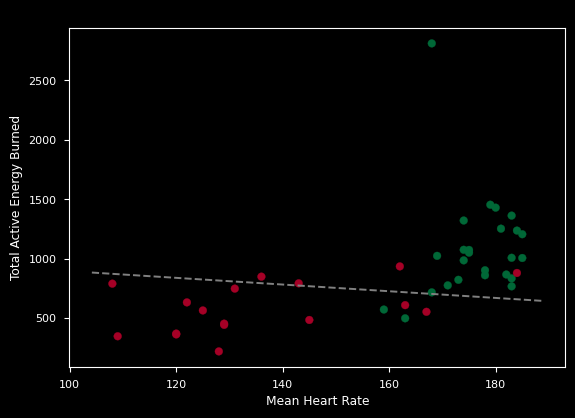

In [24]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('mplstyle.mplstyle')
plt.style.use('seaborn-v0_8-paper') # Use a simple and muted style
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='gray')  # Use a neutral color for the line


plt.scatter(x=[i.MaxHeartRate for i in train], y=[i.TotalActiveEnergyBurned for i in train], c=[i.didIRun for i in train], cmap='RdYlGn') 
plt.title("Mean Heart Rate vs Total Active Energy Burned", color='black')
plt.ylabel("Total Active Energy Burned")
plt.xlabel("Mean Heart Rate")
abline(slope, intercept)

# LDA as a dimensionality reduction technique

The equation of this decision boundary is a linear combination of the original features, and it effectively represents a one-dimensional subspace within the original 2D space. After projecting all points onto the decision boundary, we obtain a set of 1D coordinates corresponding to their positions on this line.
These 1D coordinates can be considered as a reduced-dimensional representation of the original 2D data, capturing the essential information relevant to the decision boundary.

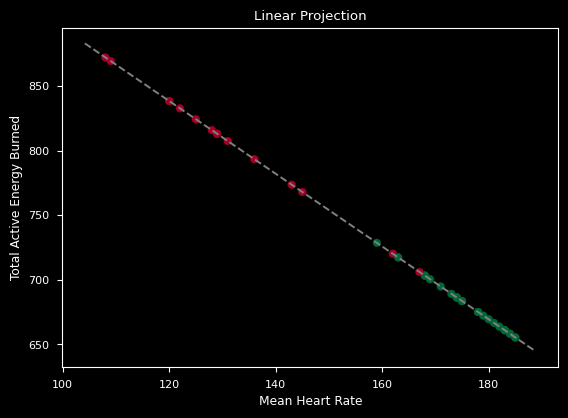

In [26]:
from linear_algebra_dumb_implementation import linear_projection
plt.scatter(x=[i.MaxHeartRate for i in train], y=[linear_projection([(i.MaxHeartRate, i.TotalActiveEnergyBurned)], slope, intercept)[0][1] for i in train], c=[i.didIRun for i in train], cmap='RdYlGn')
plt.title("Linear Projection")
plt.ylabel("Total Active Energy Burned")
plt.xlabel("Mean Heart Rate")
abline(slope, intercept)

Text(0.5, 0, 'Mean Heart Rate')

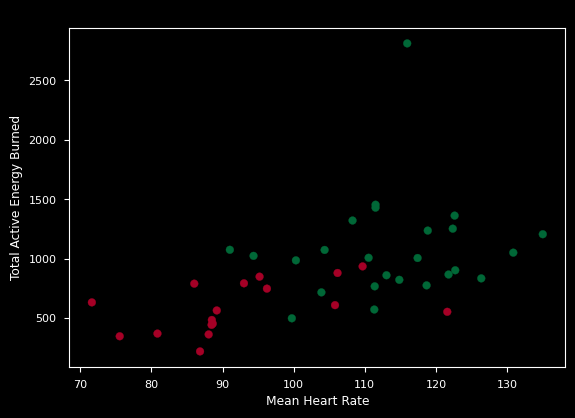

In [29]:

plt.scatter(x=[i.MeanHeartRate for i in train], y=[i.TotalActiveEnergyBurned for i in train], c=[i.didIRun for i in train], cmap='RdYlGn') 
plt.title("Mean Heart Rate vs Total Active Energy Burned", color='black')
plt.ylabel("Total Active Energy Burned")
plt.xlabel("Mean Heart Rate")